<h1> Imports

In [584]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import nltk
import os
import random

In [585]:
# !pip install torchtext==0.10.0 --user

In [586]:
# !pip install torch==1.11.0 torchtext==0.12.0 --user

In [587]:
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

<h1>Import Data

In [588]:
max_words = 25

In [589]:
data = pd.read_csv('../Data/news-article-categories-clean.csv')

<h1> Vocabulary

In [590]:
tokenizer = get_tokenizer("basic_english")

data['tok_body'] = data.body.apply(lambda x: tokenizer(x))

vocab = build_vocab_from_iterator(data['tok_body'], min_freq=1, specials=["<UNK>"])

vocab.set_default_index(vocab["<UNK>"])

len(vocab)

66936

<h1> Tokenization

In [591]:
data["cat"] = pd.Categorical(data.category)
data['cat_code'] = data.cat.cat.codes

In [592]:
data["body_tok"] = data["body"].apply(lambda x: vocab(tokenizer(x)))

In [593]:
data["body_max_len"] = data["body_tok"].apply(lambda x: x+([0]* (max_words-len(x))) if len(x)<max_words else x[:max_words])

In [594]:
# data = data.drop(data[data["cat_code"]==0].index)

In [595]:
data_sans_na = data.dropna()
data_sans_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6871 entries, 0 to 6870
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   category      6871 non-null   object  
 1   title         6871 non-null   object  
 2   body          6871 non-null   object  
 3   tok_body      6871 non-null   object  
 4   cat           6871 non-null   category
 5   cat_code      6871 non-null   int8    
 6   body_tok      6871 non-null   object  
 7   body_max_len  6871 non-null   object  
dtypes: category(1), int8(1), object(6)
memory usage: 336.3+ KB


<h1>Target Classes

In [596]:
target_classes = ["ART & CULTURE","BUSINESS","COMEDY","CRIME","EDUCATION","ENTERTAINMENT","ENVIRONMENT","MEDIA","POLITICS","RELIGION","SCIENCE","SPORTS","TECH","WOMEN"]
# target_classes = ["BUSINESS","COMEDY","CRIME","EDUCATION","ENTERTAINMENT","ENVIRONMENT","MEDIA","POLITICS","RELIGION","SCIENCE","SPORTS","TECH","WOMEN"]

In [597]:
len(target_classes)

14

In [598]:
target_classes_int = [i for i in range(14)]

<h1>Train / Test Split

In [599]:
X = data_sans_na.drop(["category", "cat_code", "cat"], axis =1)
y = data_sans_na["cat_code"]

In [600]:
X.head()

,title,body,tok_body,body_tok,body_max_len
0,Modeling Agencies Enabled Sexual Predators For...,october carolyn kramer received disturbing pho...,"[october, carolyn, kramer, received, disturbin...","[1298, 8062, 5640, 555, 2648, 404, 151, 120, 4...","[1298, 8062, 5640, 555, 2648, 404, 151, 120, 4..."
1,Actor Jeff Hiller Talks “Bright Colors And Bol...,week talked actor jeff hiller hit broadway pla...,"[week, talked, actor, jeff, hiller, hit, broad...","[58, 1515, 575, 1825, 23777, 531, 1370, 161, 2...","[58, 1515, 575, 1825, 23777, 531, 1370, 161, 2..."
2,New Yorker Cover Puts Trump 'In The Hole' Afte...,new yorker taking president donald trump asked...,"[new, yorker, taking, president, donald, trump...","[8, 2833, 366, 34, 174, 12, 199, 9, 1646, 613,...","[8, 2833, 366, 34, 174, 12, 199, 9, 1646, 613,..."
3,Man Surprises Girlfriend By Drawing Them In Di...,kellen hickey year old life hudson wisconsin g...,"[kellen, hickey, year, old, life, hudson, wisc...","[37533, 10231, 3, 90, 24, 8104, 3072, 1278, 84...","[37533, 10231, 3, 90, 24, 8104, 3072, 1278, 84..."
4,This Artist Gives Renaissance-Style Sculptures...,something combining traditional uptight look r...,"[something, combining, traditional, uptight, l...","[81, 5485, 941, 33242, 95, 6082, 799, 933, 25,...","[81, 5485, 941, 33242, 95, 6082, 799, 933, 25,..."


In [601]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: cat_code, dtype: int8

In [602]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [603]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

<h1> Vectorize Batch

In [604]:
def vectorize_batch(batch):
    Y = tuple(map(lambda x: x["label"], batch))
    X = tuple(map(lambda x: x["text"], batch))
    X_t = torch.tensor(X,dtype=torch.long)
    Y_t = torch.tensor(Y, dtype=torch.long)
    return X_t, Y_t 
   

<h1> Load Data

In [605]:
# Définir une classe pour transformer un Dataframe en Dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['body_max_len']
        label = row['cat_code']
        return {'label': label, 'text': text}

# Créer une instance de la classe Dataset personnalisée
train_dataset = CustomDataset(train)
test_dataset = CustomDataset(test)

train_dataset, test_dataset  = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [606]:
train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn= vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=1024, collate_fn=vectorize_batch)

In [607]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 25]) torch.Size([1024])


<h1> RNN

In [608]:
#Paramètres du modèle
EMBED_LEN = 200
HIDDEN_SIZE1 = 200
HIDDEN_SIZE2 = 100
HIDDEN_SIZE3 = 150
OUTPUT_SIZE = len(target_classes)
N_LAYERS = 5

In [609]:
#Classe pour le modèle RNN simple
class RNNClassifier1(nn.Module):
    def __init__(self):
        super(RNNClassifier1, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
        self.rnn = nn.RNN(input_size=EMBED_LEN, hidden_size=HIDDEN_SIZE1, num_layers=N_LAYERS, batch_first=True)
        self.linear = nn.Linear(HIDDEN_SIZE1, OUTPUT_SIZE)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings, torch.randn(N_LAYERS, len(X_batch), HIDDEN_SIZE1))
        return self.linear(output[:,-1])

In [610]:
#Classe pour le modèle a multiple RNN 
class RNNClassifier2(nn.Module):
    def __init__(self):
        super(RNNClassifier2, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
        self.rnn1 = nn.RNN(input_size=EMBED_LEN, hidden_size=HIDDEN_SIZE1, num_layers=N_LAYERS, batch_first=True)
        self.rnn2 = nn.RNN(input_size=HIDDEN_SIZE1, hidden_size=HIDDEN_SIZE2, num_layers=N_LAYERS, batch_first=True)
        self.rnn3 = nn.RNN(input_size=HIDDEN_SIZE2, hidden_size=HIDDEN_SIZE3, num_layers=N_LAYERS, batch_first=True)
        self.linear = nn.Linear(HIDDEN_SIZE3, OUTPUT_SIZE)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn1(embeddings, torch.randn(N_LAYERS, len(X_batch), HIDDEN_SIZE1))
        output, hidden = self.rnn2(output, torch.randn(N_LAYERS, len(X_batch), HIDDEN_SIZE2))
        output, hidden = self.rnn3(output, torch.randn(N_LAYERS, len(X_batch), HIDDEN_SIZE3))
        return self.linear(output[:,-1])

In [611]:
rnn_classifier1 = RNNClassifier1()

rnn_classifier1

RNNClassifier1(
  (embedding_layer): Embedding(66936, 200)
  (rnn): RNN(200, 200, num_layers=5, batch_first=True)
  (linear): Linear(in_features=200, out_features=14, bias=True)
)

In [612]:
rnn_classifier2 = RNNClassifier2()

rnn_classifier2

RNNClassifier2(
  (embedding_layer): Embedding(66936, 200)
  (rnn1): RNN(200, 200, num_layers=5, batch_first=True)
  (rnn2): RNN(200, 100, num_layers=5, batch_first=True)
  (rnn3): RNN(100, 150, num_layers=5, batch_first=True)
  (linear): Linear(in_features=150, out_features=14, bias=True)
)

In [613]:
for layer in rnn_classifier.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(66936, 50)
Parameters : 
torch.Size([66936, 50])

Layer : RNN(50, 50, num_layers=5, batch_first=True)
Parameters : 
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])

Layer : RNN(50, 60, num_layers=5, batch_first=True)
Parameters : 
torch.Size([60, 50])
torch.Size([60, 60])
torch.Size([60])
torch.Size([60])
torch.Size([60, 60])
torch.Size([60, 60])
torch.Size([60])
torch.Size([60])
torch.Size([60, 60])
torch.Size([60, 60])
torch.Size([60])
torch.Size([60])
torch.Size([60, 60])
torch.Size([60, 60])
torch.Size([60])
torch.Size([60])
torch.Size([60, 60])
torch.Size([60, 60])
torch.Size([60])
torch.Size([60])

Layer : RNN(60, 75, num_layers=5, batc

In [614]:
out = rnn_classifier1(torch.randint(0, len(vocab), (1024, max_words)))

out.shape

torch.Size([1024, 14])

In [615]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def calc_val_loss_and_accuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


def train_model(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        calc_val_loss_and_accuracy(model, loss_fn, val_loader)

<h1> Entrainement Single RNN

In [616]:
from torch.optim import Adam

epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNNClassifier1()
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

In [617]:
train_model(rnn_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


Train Loss : 2.600
Valid Loss : 2.593
Valid Acc  : 0.132


100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Train Loss : 2.498
Valid Loss : 2.560
Valid Acc  : 0.142


100%|██████████| 6/6 [00:05<00:00,  1.00it/s]


Train Loss : 2.362
Valid Loss : 2.537
Valid Acc  : 0.172


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Train Loss : 2.182
Valid Loss : 2.508
Valid Acc  : 0.175


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Train Loss : 1.997
Valid Loss : 2.517
Valid Acc  : 0.181


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Train Loss : 1.814
Valid Loss : 2.544
Valid Acc  : 0.191


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Train Loss : 1.601
Valid Loss : 2.527
Valid Acc  : 0.219


100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


Train Loss : 1.406
Valid Loss : 2.676
Valid Acc  : 0.198


100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Train Loss : 1.217
Valid Loss : 2.764
Valid Acc  : 0.226


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Train Loss : 1.039
Valid Loss : 2.910
Valid Acc  : 0.210


100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Train Loss : 0.864
Valid Loss : 2.950
Valid Acc  : 0.220


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


Train Loss : 0.677
Valid Loss : 3.093
Valid Acc  : 0.233


100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


Train Loss : 0.535
Valid Loss : 3.215
Valid Acc  : 0.221


100%|██████████| 6/6 [00:05<00:00,  1.00it/s]


Train Loss : 0.400
Valid Loss : 3.338
Valid Acc  : 0.240


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Train Loss : 0.299
Valid Loss : 3.456
Valid Acc  : 0.223


In [618]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(rnn_classifier, test_loader)

In [619]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.23272727272727273

Classification Report : 
               precision    recall  f1-score   support

ART & CULTURE       0.34      0.27      0.30       193
     BUSINESS       0.17      0.18      0.17        91
       COMEDY       0.33      0.37      0.34        71
        CRIME       0.24      0.15      0.18        67
    EDUCATION       0.27      0.25      0.26       109
ENTERTAINMENT       0.23      0.30      0.26        92
  ENVIRONMENT       0.27      0.40      0.32        85
        MEDIA       0.22      0.20      0.21        66
     POLITICS       0.20      0.14      0.16       112
     RELIGION       0.05      0.07      0.06        90
      SCIENCE       0.22      0.16      0.19        87
       SPORTS       0.26      0.22      0.24       108
         TECH       0.23      0.30      0.26       101
        WOMEN       0.21      0.23      0.22       103

     accuracy                           0.23      1375
    macro avg       0.23      0.23      0.23      1375
 

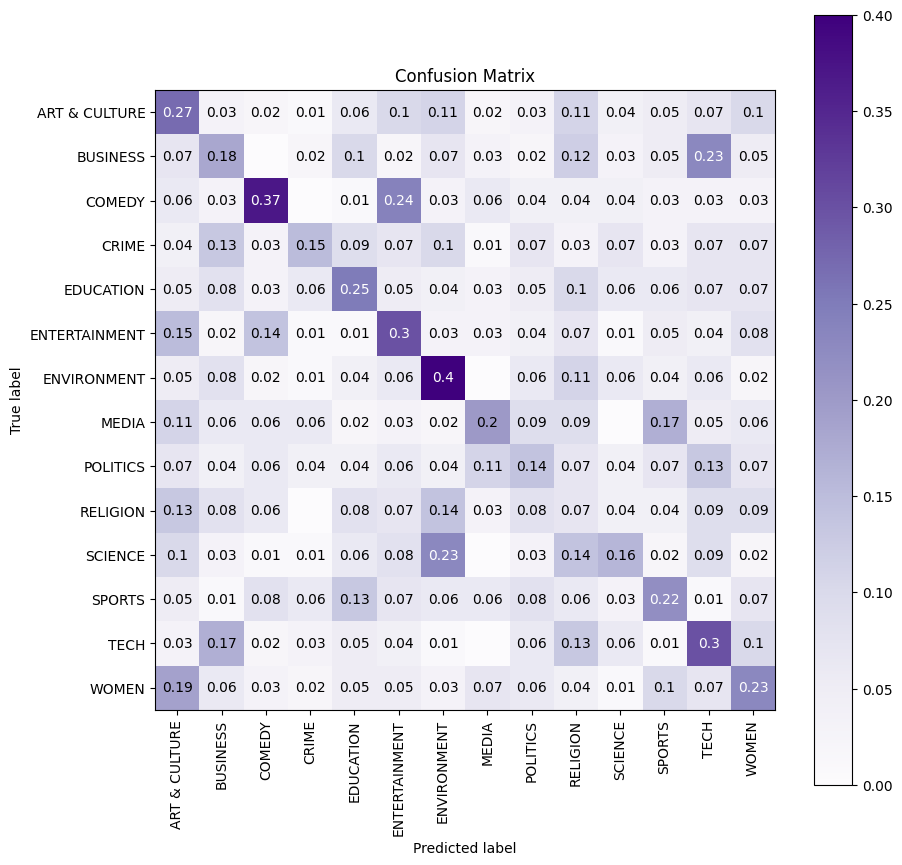

In [620]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(10,10)
                                    );
plt.xticks(rotation=90);

<h1> Entrainement Multi RNN

In [621]:
epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNNClassifier2()
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

In [622]:
train_model(rnn_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


Train Loss : 2.601
Valid Loss : 2.611
Valid Acc  : 0.140


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Train Loss : 2.575
Valid Loss : 2.596
Valid Acc  : 0.143


100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Train Loss : 2.544
Valid Loss : 2.580
Valid Acc  : 0.140


100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Train Loss : 2.559
Valid Loss : 2.575
Valid Acc  : 0.132


100%|██████████| 6/6 [00:11<00:00,  1.99s/it]


Train Loss : 2.501
Valid Loss : 2.549
Valid Acc  : 0.136


100%|██████████| 6/6 [00:11<00:00,  1.97s/it]


Train Loss : 2.481
Valid Loss : 2.562
Valid Acc  : 0.137


100%|██████████| 6/6 [00:12<00:00,  2.04s/it]


Train Loss : 2.459
Valid Loss : 2.559
Valid Acc  : 0.141


100%|██████████| 6/6 [00:12<00:00,  2.01s/it]


Train Loss : 2.433
Valid Loss : 2.559
Valid Acc  : 0.145


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Train Loss : 2.403
Valid Loss : 2.554
Valid Acc  : 0.154


100%|██████████| 6/6 [00:11<00:00,  1.99s/it]


Train Loss : 2.397
Valid Loss : 2.559
Valid Acc  : 0.144


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Train Loss : 2.381
Valid Loss : 2.551
Valid Acc  : 0.148


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Train Loss : 2.351
Valid Loss : 2.549
Valid Acc  : 0.164


100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Train Loss : 2.330
Valid Loss : 2.597
Valid Acc  : 0.151


100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Train Loss : 2.314
Valid Loss : 2.584
Valid Acc  : 0.158


100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


Train Loss : 2.285
Valid Loss : 2.575
Valid Acc  : 0.151


In [623]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.23272727272727273

Classification Report : 
               precision    recall  f1-score   support

ART & CULTURE       0.34      0.27      0.30       193
     BUSINESS       0.17      0.18      0.17        91
       COMEDY       0.33      0.37      0.34        71
        CRIME       0.24      0.15      0.18        67
    EDUCATION       0.27      0.25      0.26       109
ENTERTAINMENT       0.23      0.30      0.26        92
  ENVIRONMENT       0.27      0.40      0.32        85
        MEDIA       0.22      0.20      0.21        66
     POLITICS       0.20      0.14      0.16       112
     RELIGION       0.05      0.07      0.06        90
      SCIENCE       0.22      0.16      0.19        87
       SPORTS       0.26      0.22      0.24       108
         TECH       0.23      0.30      0.26       101
        WOMEN       0.21      0.23      0.22       103

     accuracy                           0.23      1375
    macro avg       0.23      0.23      0.23      1375
 

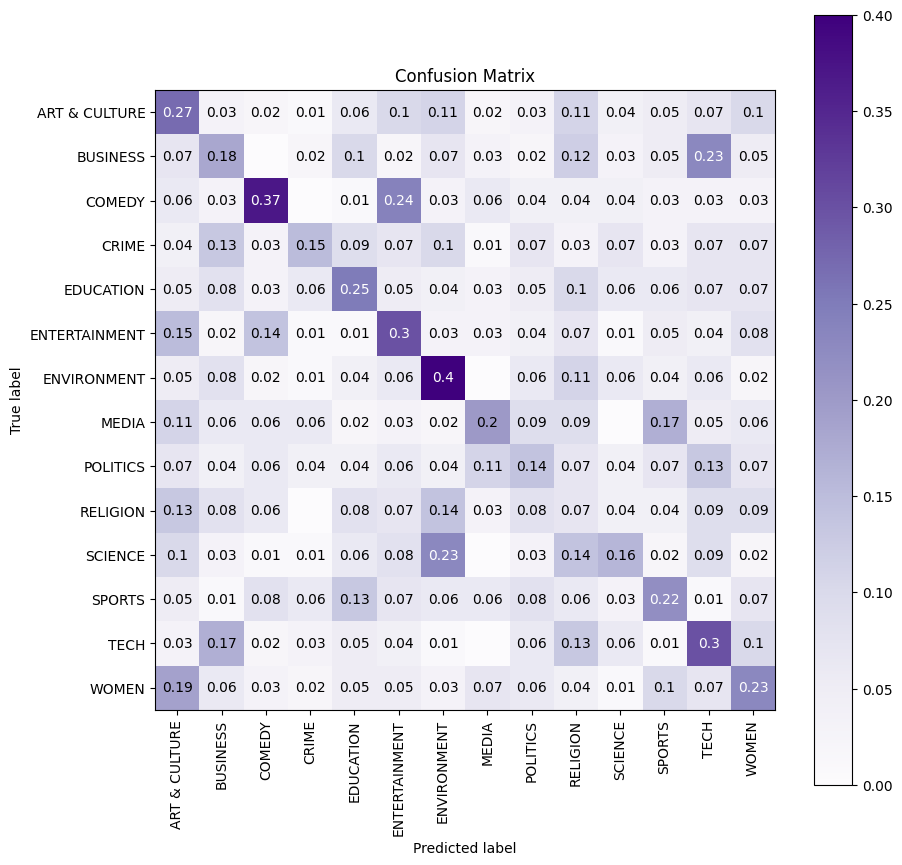

In [624]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(10,10)
                                    );
plt.xticks(rotation=90);